# calculating optimal theoretical neurogenesis curve for layer distribution

## setup

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import glob
import os

from scipy.optimize import curve_fit

color = ['#333333', '#E65912']
layer_colors = ['#ae0000', '#e33e00', '#ffc000', '#0088ab']

def gaussian(x, m, s, k):
    return k * np.exp(-((x-m)/s)**2)

### get the coefficients

In [25]:
gaus_coeff = pd.read_csv('layers_gaus_coef.csv')

### get the curves

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_19520\3897847598.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distribution_labels.append(row[-1])


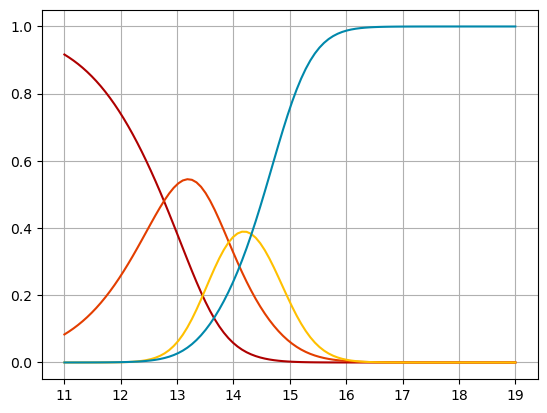

In [26]:
x_line = np.linspace(0, 8, 100)

# distributions in time per layers
distribution_labels = []
distribution = np.zeros((4, x_line.shape[0]))

for index, row in gaus_coeff.iterrows():

    # calculated function
    y_line = gaussian(x_line, *row[:-1])
    distribution_labels.append(row[-1])
    distribution[index] = y_line


tot = np.sum(distribution, axis=0)
distribution = distribution/tot

for index, l in enumerate(distribution):

    plt.plot(x_line + 11, l, color=layer_colors[index], label=f'pred')

plt.grid()

# discretization approach

Gs are the four gaussians

Fs are the four gaussians where at every 

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_19520\1128914166.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G_labels.append(row[-1])


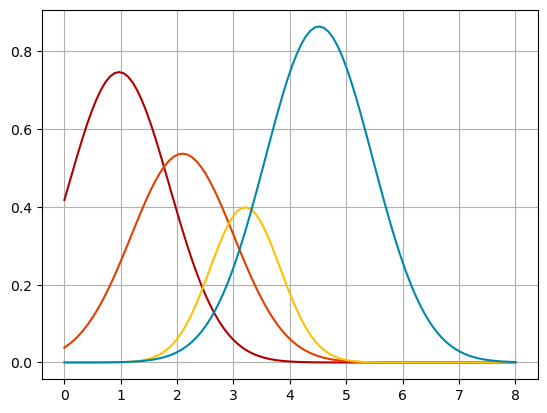

In [27]:
import cvxpy as cp

gaus_coeff = pd.read_csv('layers_gaus_coef.csv')

M = 100

x_line = np.linspace(0, 8, M)

dt = x_line[1] - x_line[0]

# distributions in time per layers
G_labels = []
G = np.zeros((4, x_line.shape[0]))

for index, row in gaus_coeff.iterrows():

    # calculated function
    y_line = gaussian(x_line, *row[:-1])
    G_labels.append(row[-1])
    G[index] = y_line


tot_t = np.sum(G, axis=0)

# at every moment the sum of the four functions is 1
F = G/tot_t

for index, l in enumerate(G):
    plt.plot(x_line, l, color=layer_colors[index], label=f'pred')
plt.grid()

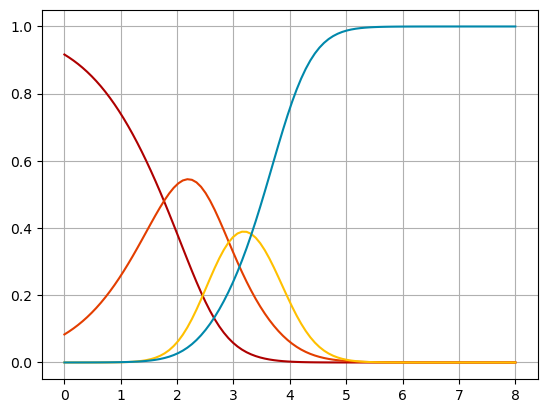

In [28]:
for index, l in enumerate(F):
    plt.plot(x_line, l, color=layer_colors[index], label=f'pred')
plt.grid()

In [29]:
l_labels = pd.read_csv('layers_percent.csv')['layer'].values[::-1]
l_data = pd.read_csv('layers_percent.csv')['percent'].values[::-1]

print(l_data)
print(l_labels)

l_exp = np.array([l_data]).squeeze()

[0.21640608 0.28861736 0.19994028 0.29503627]
['l6' 'l5' 'l4' 'l23']


### discretization of the integral

In [30]:
A_matrix = np.vstack([
    F * dt,                                     # coefficient to multiply N at each time frame, SUM(N*F*dt) equal to the four percentages in b_vector
    np.ones(M) * dt                             # SUM(1*N*dt) integral of N is 1
])

### final integral costraints (layer percentages)

In [31]:
b_vector = np.concatenate([l_exp, [1.0]])

print(b_vector)

[0.21640608 0.28861736 0.19994028 0.29503627 1.        ]


### keeping it smooth

In [32]:
# Regularization matrix D2 for second derivative
D2 = np.zeros((M-2, M))
for i in range(M-2):
    D2[i, i] = 1
    D2[i, i+1] = -2
    D2[i, i+2] = 1

lambda_reg = 1e-2 * (M/50)**3

### end point of neurogeneis at zero

In [33]:
# one row for each new costraint
A_extra_end = np.zeros((1,M))

# first costraint, time = 0
A_extra_end[0, -1] = 1

#  both equations set at zero
b_extra_end = np.array([0])

A_end = np.vstack([A_matrix, A_extra_end])
b_end = np.concatenate([b_vector, b_extra_end])

In [34]:
# one row for each new costraint
A_extra_start = np.zeros((1,M))

# seccond costraint, time = last time
A_extra_start[0,0] = 1

#  both equations set at zero
b_extra_start = np.array([0])


A_start = np.vstack([A_matrix, A_extra_start])
b_start = np.concatenate([b_vector, b_extra_start])

In [35]:
A_full = np.vstack([A_start, A_extra_end])
b_full = np.concatenate([b_start, b_extra_end])

## results

### costraints: percentages + smoothness

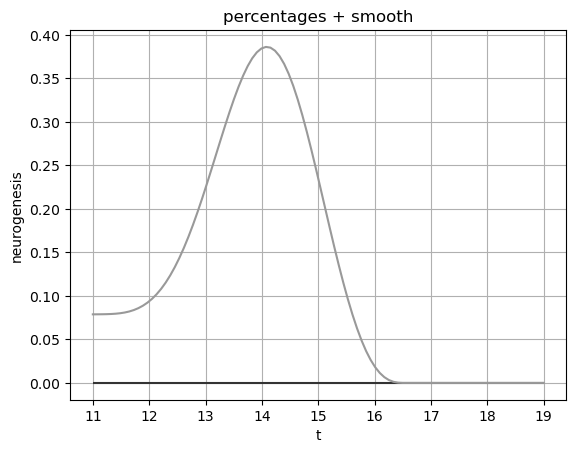

In [36]:
N = cp.Variable(M)

objective = cp.Minimize(cp.sum_squares(A_matrix @ N - b_vector) + lambda_reg * cp.sum_squares(D2 @ N))
constraints = [N >= 0]

prob = cp.Problem(objective, constraints)
prob.solve()

N_val = N.value

t = np.linspace(0, 8, M)

plt.hlines(y = 0, xmin = 11, xmax = 19, color = '#333333')
plt.plot(t+11, N_val, color = '#999999')
plt.grid()
plt.xlabel('t')
plt.ylabel('neurogenesis')
plt.title('percentages + smooth')
plt.savefig('theoretical/solution_minimal.png')
plt.savefig('theoretical/solution_minimal.pdf')
plt.show()


### costraints: percentages + smoothness + start = 0

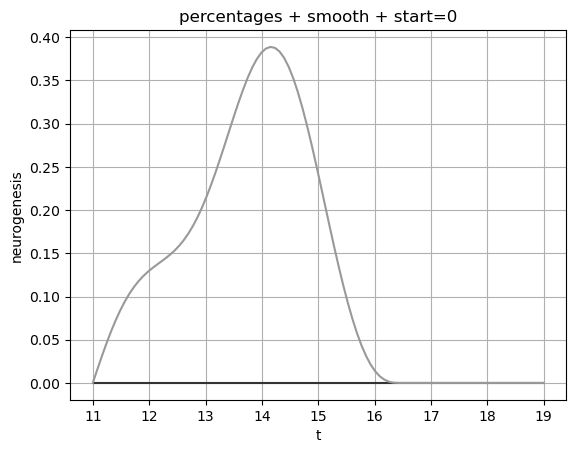

In [37]:
N = cp.Variable(M)

objective = cp.Minimize(cp.sum_squares(A_start @ N - b_start) + lambda_reg * cp.sum_squares(D2 @ N))
constraints = [N >= 0]

prob = cp.Problem(objective, constraints)
prob.solve()

N_val = N.value

t = np.linspace(0, 8, M)
plt.hlines(y = 0, xmin = 11, xmax = 19, color = '#333333')
plt.plot(t+11, N_val, color = '#999999')
plt.grid()
plt.xlabel('t')
plt.ylabel('neurogenesis')
plt.title('percentages + smooth + start=0')
plt.savefig('theoretical/solution_start.png')
plt.savefig('theoretical/solution_start.pdf')
plt.show()


### costraints: percentages + smoothness + end = 0

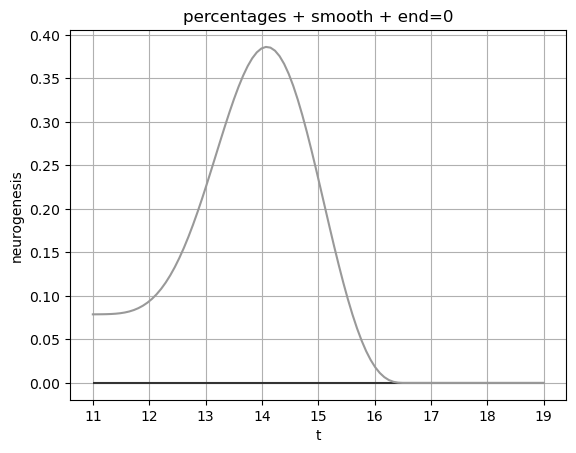

In [38]:
N = cp.Variable(M)

objective = cp.Minimize(cp.sum_squares(A_end @ N - b_end) + lambda_reg * cp.sum_squares(D2 @ N))
constraints = [N >= 0]

prob = cp.Problem(objective, constraints)
prob.solve()

N_val = N.value

t = np.linspace(0, 8, M)
plt.hlines(y = 0, xmin = 11, xmax = 19, color = '#333333')
plt.plot(t+11, N_val, color = '#999999')
plt.grid()
plt.xlabel('t')
plt.ylabel('neurogenesis')
plt.title('percentages + smooth + end=0')
plt.savefig('theoretical/solution_end.png')
plt.savefig('theoretical/solution_end.pdf')
plt.show()


### costraints: percentages + smoothness + start = 0 + end = 0

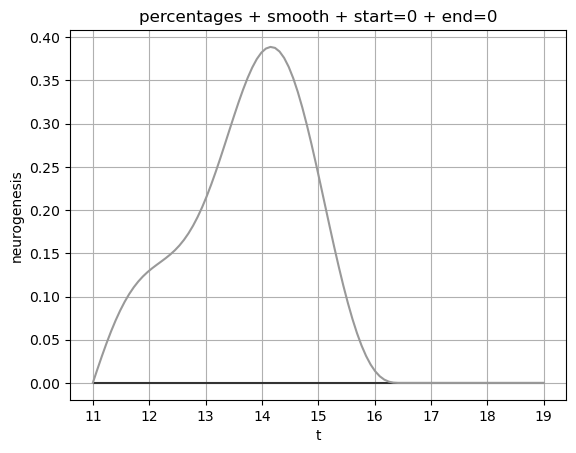

In [39]:
N = cp.Variable(M)

objective = cp.Minimize(cp.sum_squares(A_full @ N - b_full) + lambda_reg * cp.sum_squares(D2 @ N))
constraints = [N >= 0]

prob = cp.Problem(objective, constraints)
prob.solve()

N_val = N.value

t = np.linspace(0, 8, M)
plt.hlines(y = 0, xmin = 11, xmax = 19, color = '#333333')
plt.plot(t+11, N_val, color = '#999999')
plt.grid()
plt.xlabel('t')
plt.ylabel('neurogenesis')
plt.title('percentages + smooth + start=0 + end=0')
plt.savefig('theoretical/solution_all-costraints.png')
plt.savefig('theoretical/solution_all-costraints.pdf')

plt.savefig('results/theoretical neurogenesis.pdf')
plt.show()

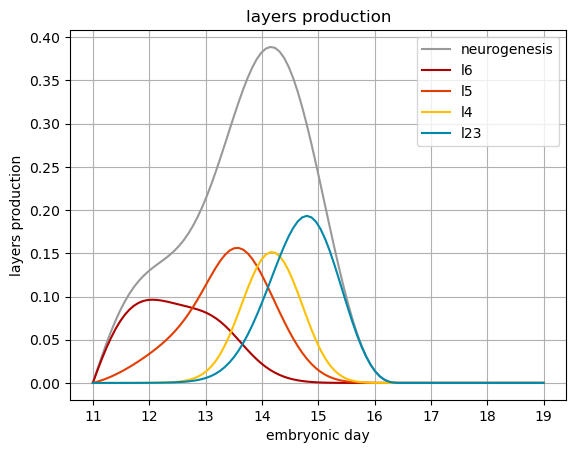

In [40]:
plt.plot(x_line + 11, N_val, color = '#999999', label = 'neurogenesis')

F_actual = np.zeros_like(F)

for index, l in enumerate(F[:]):

    c = layer_colors[index]

    F_actual[index] = l*N_val
    plt.plot(x_line + 11, l*N_val, color=c, label = distribution_labels[index])

plt.grid()
plt.title('layers production')
plt.xlabel('embryonic day')
plt.ylabel('layers production')
plt.legend(loc = 'upper right')
plt.savefig('results/theoretical_layers_prod.pdf')


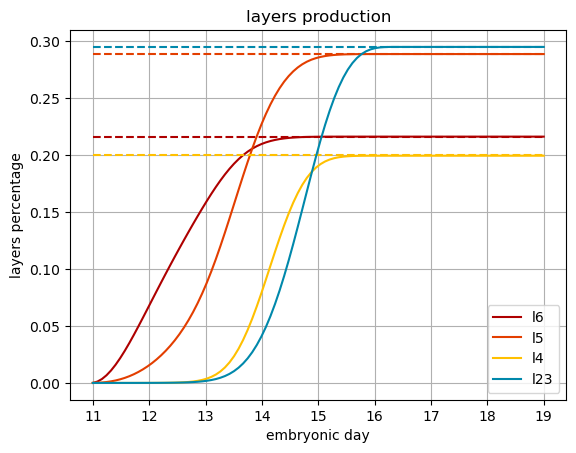

In [41]:
F_cum = np.cumsum(F_actual, axis = 1)*dt

for index, l in enumerate(layer_colors):

    c = layer_colors[index]

    current_layer =  l_exp[index]

    plt.hlines(y = current_layer, xmin = 11, xmax = 19, color = c, linestyles='--')
    plt.plot(x_line + 11, F_cum[index], color=c, label = distribution_labels[index])

plt.grid()
plt.title('layers production')
plt.xlabel('embryonic day')
plt.ylabel('layers percentage')
plt.legend(loc = 'lower right')
plt.savefig('theoretical/layers_perc.png')
plt.savefig('theoretical/layers_perc.pdf')